In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime, timezone
import ipaddress
from collections import Counter

from tqdm import tqdm

from sklearn.metrics import (
    silhouette_score as sil_,
    silhouette_samples,
    calinski_harabasz_score as calinski_,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score
)
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Input, BatchNormalization, ReLU, Add
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from tensorflow.keras.layers import Dropout
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras")
from sklearn.ensemble import RandomForestClassifier

In [2]:
import os
def load_data(directory):
    data = []
    for file in tqdm(os.listdir(directory)):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(directory, file))
            data.append(df)
    return pd.concat(data, ignore_index=True)

df = load_data('data/cic')
# Clean column names (in case of whitespace)
df.columns = df.columns.str.strip()

df = df[df['Label'] != 'BENIGN']

features = df.select_dtypes(include=[np.number]).copy()
features.replace([np.inf, -np.inf], np.nan, inplace=True)
features.dropna(inplace=True)
df = df.loc[features.index].copy()

100%|██████████| 8/8 [00:13<00:00,  1.73s/it]


In [3]:
df.reset_index(drop=True, inplace=True)

In [4]:
df["Label"].value_counts()

Label
DoS Hulk                      230124
PortScan                      158804
DDoS                          128025
DoS GoldenEye                  10293
FTP-Patator                     7935
SSH-Patator                     5897
DoS slowloris                   5796
DoS Slowhttptest                5499
Bot                             1956
Web Attack � Brute Force        1507
Web Attack � XSS                 652
Infiltration                      36
Web Attack � Sql Injection        21
Heartbleed                        11
Name: count, dtype: int64

In [5]:
def group_attack_label(label):
    if label == "BENIGN":
        return "Benign"
    elif "DDoS" in label:
        return "DDoS"
    elif "DoS" in label:
        return "DoS"
    elif "PortScan" in label:
        return "Scan"
    elif "Patator" in label:
        return "BruteForce"
    elif "Web Attack" in label:
        return "WebAttack"
    elif label in ["Bot", "Infiltration", "Heartbleed"]:
        return "Other"
    else:
        return "Unknown"

df['label_group'] = df['Label'].apply(group_attack_label)

In [6]:
df["label_group"].value_counts()

label_group
DoS           251712
Scan          158804
DDoS          128025
BruteForce     13832
WebAttack       2180
Other           2003
Name: count, dtype: int64

In [7]:
df = df.loc[:, ~df.columns.str.contains('bwd', case=False)]
df = df.loc[:, ~df.columns.str.contains('backward', case=False)]


In [8]:
import pickle
with open('data/grouped_df.pkl', 'rb') as f:
    grouped_df = pickle.load(f)
grouped_df

,cic_Total Fwd Packets,cic_Total Length of Fwd Packets,cic_Fwd Packet Length Mean,cic_Fwd Packet Length Min,cic_Fwd Packet Length Max,cic_Fwd Packet Length Std,cic_Packet Length Variance,cic_Flow IAT Mean,cic_Flow IAT Std,cic_Flow IAT Min,...,dst_country_emb_2_first,dst_country_emb_3_first,dst_country_emb_4_first,dst_country_emb_5_first,dst_country_emb_6_first,dst_country_emb_7_first,dst_country_emb_8_first,dst_country_emb_9_first,cic_Fwd IAT Total,cic_Destination Port
0,1.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.0,0.00000,0.0,...,-0.001585,0.100905,-0.065801,0.297281,0.305936,-0.159620,0.116160,-0.044771,0,23
1,1.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.0,0.00000,0.0,...,-0.047310,-0.011996,0.005260,-0.025826,-0.004693,0.013444,0.013675,-0.007392,0,23
3,1.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.0,0.00000,0.0,...,-0.001585,0.100905,-0.065801,0.297281,0.305936,-0.159620,0.116160,-0.044771,0,23
4,1.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.0,0.00000,0.0,...,-0.105995,-0.107222,0.117179,-0.348651,0.276392,0.075724,-0.134629,0.061312,0,23
6,4.0,239.0,59.75,0.0,147.0,72.555151,5264.25,16.5,17.67767,4.0,...,-0.047310,-0.011996,0.005260,-0.025826,-0.004693,0.013444,0.013675,-0.007392,33,445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381478,1.0,133.0,133.00,133.0,133.0,0.000000,0.00,0.0,0.00000,0.0,...,0.040023,0.056062,0.007198,0.258058,0.090996,-0.054872,0.113645,-0.099819,0,80
381479,1.0,97.0,97.00,97.0,97.0,0.000000,0.00,0.0,0.00000,0.0,...,-0.087578,0.331180,-0.106147,-0.040069,-0.212324,0.055434,0.027325,0.007878,0,80
381480,1.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.0,0.00000,0.0,...,0.098074,0.063331,-0.045459,-0.107533,-0.084309,-0.155936,-0.095196,-0.385889,0,23
381481,1.0,22.0,22.00,22.0,22.0,0.000000,0.00,0.0,0.00000,0.0,...,0.098074,0.063331,-0.045459,-0.107533,-0.084309,-0.155936,-0.095196,-0.385889,0,22


In [9]:
cic_columns = grouped_df.filter(regex='^cic').columns
grouped_df = grouped_df[[col for col in grouped_df.columns if 'emb' not in col]]
grouped_df_cic = grouped_df[cic_columns]

checking the IAT didstribution in more details as omni has virtually 0 IAT so I drop the features

In [10]:
IAT = grouped_df.filter(regex="IAT*").columns
grouped_df[IAT].describe()

,cic_Flow IAT Mean,cic_Flow IAT Std,cic_Flow IAT Min,cic_Flow IAT Max,cic_Fwd IAT Mean,cic_Fwd IAT Std,cic_Fwd IAT Max,cic_Fwd IAT Min,cic_Fwd IAT Total
count,331740.000000,331740.000000,331740.000000,331740.000000,331740.000000,331740.000000,331740.000000,331740.000000,331740.000000
mean,1.471930,1.147177,0.618713,2.565078,1.471930,1.147177,2.565078,0.618713,5.021185
std,7.639938,6.555068,4.594769,12.900305,7.639938,6.555068,12.900305,4.594769,32.076577
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,120.000000,84.145707,120.000000,120.000000,120.000000,84.145707,120.000000,120.000000,1508.000000


In [11]:
df[df.filter(regex="IAT").columns].describe()

,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min
count,5.565560e+05,5.565560e+05,5.565560e+05,5.565560e+05,5.565560e+05,5.565560e+05,5.565560e+05,5.565560e+05,5.565560e+05
mean,2.892205e+06,8.405503e+06,2.843157e+07,2.233378e+05,2.914620e+07,5.514674e+06,1.151668e+07,2.834528e+07,5.415419e+05
std,5.563720e+06,1.229449e+07,4.150648e+07,3.838665e+06,4.233110e+07,9.928093e+06,1.729540e+07,4.156235e+07,6.737672e+06
min,5.000000e-01,0.000000e+00,1.000000e+00,-1.300000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.200000e+01
25%,4.900000e+01,0.000000e+00,4.900000e+01,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.659430e+04,7.881581e+04,2.758915e+05,5.000000e+00,8.350000e+03,4.013500e+03,1.989798e+03,8.002000e+03,1.000000e+00
75%,6.578468e+06,2.290000e+07,8.350000e+07,4.800000e+01,8.410000e+07,1.190000e+07,3.020000e+07,8.350000e+07,1.800000e+01
max,1.200000e+08,8.370000e+07,1.200000e+08,1.200000e+08,1.200000e+08,1.200000e+08,8.370000e+07,1.200000e+08,1.200000e+08


In [12]:
grouped_df_cic.drop(columns=grouped_df.filter(regex="IAT*").columns, inplace=True)

C:\Users\luca.lucchina\AppData\Local\Temp\ipykernel_18552\3832905226.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_df_cic.drop(columns=grouped_df.filter(regex="IAT*").columns, inplace=True)


In [13]:
import pandas as pd

feature_mapping = [
    ('Destination Port', 'cic_Destination Port'),
    ('Flow Duration', 'cic_Flow Duration'),
    ('Total Fwd Packets', 'cic_Total Fwd Packets'),
    ('Total Length of Fwd Packets', 'cic_Total Length of Fwd Packets'),
    ('Fwd Packet Length Max', 'cic_Fwd Packet Length Max'),
    ('Fwd Packet Length Min', 'cic_Fwd Packet Length Min'),
    ('Fwd Packet Length Mean', 'cic_Fwd Packet Length Mean'),
    ('Fwd Packet Length Std', 'cic_Fwd Packet Length Std'),
    ('Flow Bytes/s', 'cic_Flow Bytes/s'),
    ('Flow Packets/s', 'cic_Flow Packets/s'),
    ('Fwd Packets/s', 'cic_Fwd Packets/s'),
    ('Min Packet Length', 'cic_Min Packet Length'),
    ('Max Packet Length', 'cic_Max Packet Length'),
    ('Packet Length Mean', 'cic_Packet Length Mean'),
    ('Packet Length Std', 'cic_Packet Length Std'),
    ('Packet Length Variance', 'cic_Packet Length Variance'),
    ('Average Packet Size', 'cic_Average Packet Size'),
    ('Avg Fwd Segment Size', 'cic_Avg Fwd Segment Size')
]

rename_dict = {cic_name: new_name for new_name, cic_name in feature_mapping}
grouped_df_cic.rename(columns=rename_dict, inplace=True)

C:\Users\luca.lucchina\AppData\Local\Temp\ipykernel_18552\3456617792.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_df_cic.rename(columns=rename_dict, inplace=True)


In [14]:
columns = list(grouped_df_cic.columns)
columns.append("label_group")

In [15]:
df = df[columns]
df

,Total Fwd Packets,Total Length of Fwd Packets,Fwd Packet Length Mean,Fwd Packet Length Min,Fwd Packet Length Max,Fwd Packet Length Std,Packet Length Variance,Flow Duration,Flow Bytes/s,Flow Packets/s,Fwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Average Packet Size,Avg Fwd Segment Size,Destination Port,label_group
0,3,26,8.666667,0,20,10.263203,3.435231e+06,1293792,8991.398927,7.729218,2.318765,0,5840,1057.545455,1853.437529,1163.300000,8.666667,80,DDoS
1,4,24,6.000000,6,6,0.000000,0.000000e+00,4421382,5.428167,0.904695,0.904695,6,6,6.000000,0.000000,7.500000,6.000000,80,DDoS
2,3,26,8.666667,0,20,10.263203,2.706820e+06,1083538,10730.588130,8.306123,2.768708,0,4380,1162.700000,1645.241762,1291.888889,8.666667,80,DDoS
3,8,56,7.000000,0,20,5.656854,6.192667e+06,80034360,145.649943,0.149936,0.099957,0,8760,897.153846,2488.507044,971.916667,7.000000,80,DDoS
4,3,26,8.666667,0,20,10.263203,4.572452e+06,642654,18101.497850,14.004425,4.668142,0,5840,1163.300000,2138.329153,1292.555556,8.666667,80,DDoS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556551,8,326,40.750000,0,326,115.258405,7.361769e+06,11512204,1038.723775,1.129236,0.694915,0,10184,854.142857,2713.257986,919.846154,40.750000,80,DoS
556552,5,471,94.200000,0,471,210.637604,5.180836e+05,11513325,347.076105,0.868559,0.434279,0,2077,363.272727,719.780257,399.600000,94.200000,80,DoS
556553,7,314,44.857143,0,314,118.680845,3.449144e+06,11509201,1037.952157,1.129531,0.608209,0,5792,853.285714,1857.187221,918.923077,44.857143,80,DoS
556554,8,369,46.125000,0,369,130.461201,7.358407e+06,11509095,1042.740546,1.129541,0.695102,0,10184,857.214286,2712.638403,923.153846,46.125000,80,DoS


In [16]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [17]:
df.shape

(556556, 19)

In [18]:
df['label_group'].value_counts()

label_group
DoS           251712
Scan          158804
DDoS          128025
BruteForce     13832
WebAttack       2180
Other           2003
Name: count, dtype: int64

In [19]:
label_counts = df['label_group'].value_counts()
labels_to_keep = label_counts[label_counts >= 1000].index
df = df[df['label_group'].isin(labels_to_keep)].copy()

In [20]:
le = LabelEncoder()

df['label_encoded'] = le.fit_transform(df['label_group'])
for i, label in enumerate(le.classes_):
    print(f"{label}: {i}")
print("\nUnique encoded values:", df['label_encoded'].unique())
print("Original labels:", df['label_group'].unique())
df.drop(columns=["label_group"], inplace=True)

BruteForce: 0
DDoS: 1
DoS: 2
Other: 3
Scan: 4
WebAttack: 5

Unique encoded values: [1 4 3 5 0 2]
Original labels: ['DDoS' 'Scan' 'Other' 'WebAttack' 'BruteForce' 'DoS']


# Evaluating the difference between datasets via a discrimination model

In [21]:
grouped_df_cic["binary_label"] = 0

C:\Users\luca.lucchina\AppData\Local\Temp\ipykernel_18552\3560432524.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_df_cic["binary_label"] = 0


In [22]:
df["binary_label"] = 1

In [23]:
col_drop = ["binary_label"]#, "Flow Duration"]#, "Flow Bytes/s", "Flow Packets/s", "Min Packet Length", "Average Packet Size", "Packet Length Variance", "Total Length of Fwd Packets", "Max Packet Length","Fwd Packet Length Max"]
comb = pd.concat([grouped_df_cic, df.drop(columns=["label_encoded"])], ignore_index=True)
comb.reset_index(drop=True, inplace=True)
x = comb.drop(columns=col_drop)
y = comb["binary_label"]

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3)

scaler = QuantileTransformer()
scaler.fit(x_train)
x_train = pd.DataFrame(scaler.transform(x_train), columns=x.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x.columns)

In [24]:
model = Sequential()
model.add(Input(shape=(x_train.shape[1],)))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
model.fit(x_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
15546/15546 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step - accuracy: 0.9986 - loss: 0.0048 - val_accuracy: 1.0000 - val_loss: 2.3498e-07
Epoch 2/5
15546/15546 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step - accuracy: 0.9999 - loss: 2.7200e-04 - val_accuracy: 1.0000 - val_loss: 7.1654e-09
Epoch 3/5
15546/15546 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step - accuracy: 1.0000 - loss: 1.1436e-04 - val_accuracy: 1.0000 - val_loss: 2.1362e-09
Epoch 4/5
15546/15546 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step - accuracy: 1.0000 - loss: 4.6886e-05 - val_accuracy: 1.0000 - val_loss: 1.1180e-10
Epoch 5/5
15546/15546 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step - accuracy: 1.0000 - loss: 9.3630e-05 - val_accuracy: 1.0000 - val_loss: 1.6548e-10


8328/8328 ━━━━━━━━━━━━━━━━━━━━ 5s 538us/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99382
           1       1.00      1.00      1.00    167107

    accuracy                           1.00    266489
   macro avg       1.00      1.00      1.00    266489
weighted avg       1.00      1.00      1.00    266489



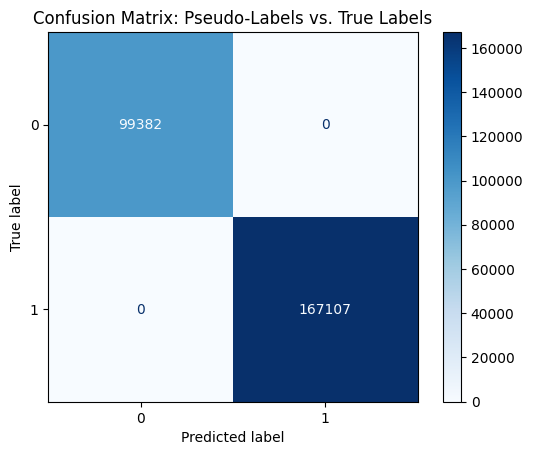

In [26]:
pred = model.predict(x_test)

print(classification_report(y_test, (pred > 0.5).astype(int)))

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, (pred > 0.5).astype(int)))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: Pseudo-Labels vs. True Labels")
plt.show()

C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PermutationExplainer explainer: 201it [00:24,  6.90it/s]                         
C:\Users\luca.lucchina\AppData\Local\Temp\ipykernel_18552\788365922.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, x_test[:200], feature_names=x_train.columns.tolist())


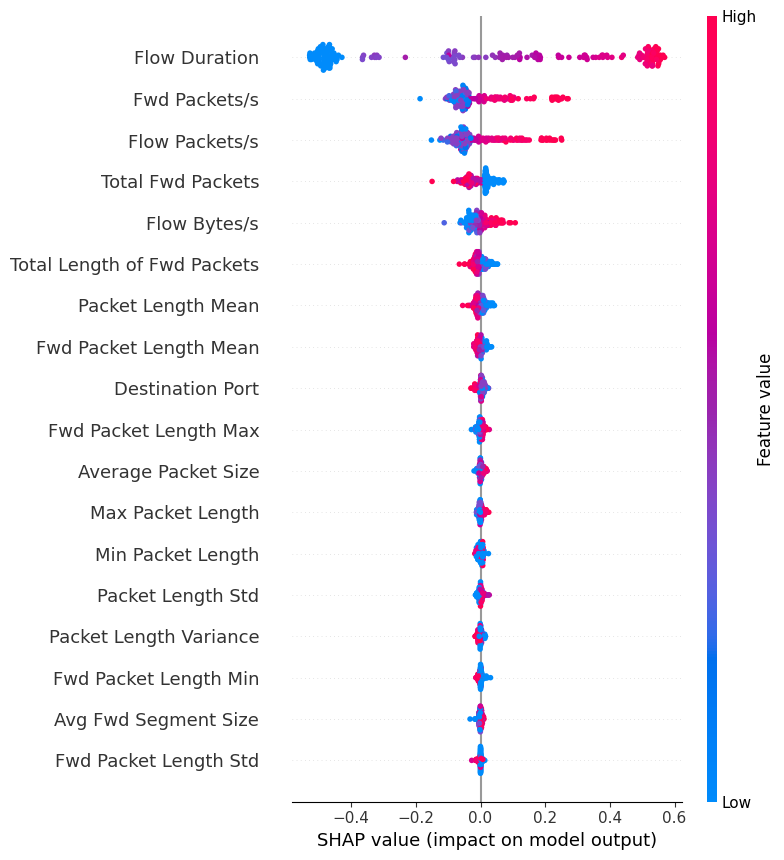

In [27]:
import shap

background = x_train.iloc[np.random.choice(x_train.shape[0], 100, replace=False)]

explainer = shap.Explainer(model, background)
shap_values = explainer(x_test[:200])

shap.summary_plot(shap_values, x_test[:200], feature_names=x_train.columns.tolist())

this show cases that the two datasets are vastly different and that applying the curriculum learning process would not be trustable 100%, to add trustworthiness to the learning process several mehtods can be added:
- teacher models
- add an ensamble methodology to broaden the view of the predictions

This comement was added later after testing the curriculum learning thought the cic dataset only as I thought I was going to aquire some high confidence labels for the omni port dataset

In [28]:
cic = df.drop(columns=["label_encoded", "binary_label"])
cic_target = df["label_encoded"]

omni = grouped_df_cic.drop(columns=["binary_label"])


scaler = QuantileTransformer()
scaler.fit(cic)
x_labeled = pd.DataFrame(scaler.transform(cic), columns=cic.columns)
x_unlabeled = pd.DataFrame(scaler.transform(omni), columns=cic.columns)
y_labeled = cic_target.copy()

In [29]:
cic_target.value_counts()

label_encoded
2    251712
4    158804
1    128025
0     13832
5      2180
3      2003
Name: count, dtype: int64

In [30]:
x_labeled = x_labeled.drop(columns=col_drop, errors="ignore")
x_unlabeled = x_unlabeled.drop(columns=col_drop, errors="ignore")

In [31]:
x_train, x_test, y_train, y_test = train_test_split(x_labeled, y_labeled,train_size=0.7)

In [32]:
y_train.unique()

array([4, 2, 1, 5, 0, 3])

In [33]:
model = Sequential()
model.add(Input(shape=(x_train.shape[1],)))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))

model.add(Dense(len(y_train.unique()), activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [34]:
model.fit(x_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
9740/9740 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.9900 - loss: 0.0369 - val_accuracy: 0.9986 - val_loss: 0.0080
Epoch 2/5
9740/9740 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.9971 - loss: 0.0101 - val_accuracy: 0.9988 - val_loss: 0.0049
Epoch 3/5
9740/9740 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.9983 - loss: 0.0067 - val_accuracy: 0.9981 - val_loss: 0.0056
Epoch 4/5
9740/9740 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.9986 - loss: 0.0059 - val_accuracy: 0.9991 - val_loss: 0.0041
Epoch 5/5
9740/9740 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.9985 - loss: 0.0057 - val_accuracy: 0.9961 - val_loss: 0.0129


5218/5218 ━━━━━━━━━━━━━━━━━━━━ 3s 635us/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4146
           1       0.99      1.00      0.99     38181
           2       1.00      0.99      1.00     75689
           3       0.99      1.00      0.99       595
           4       1.00      1.00      1.00     47643
           5       0.99      0.81      0.89       713

    accuracy                           1.00    166967
   macro avg       0.99      0.97      0.98    166967
weighted avg       1.00      1.00      1.00    166967



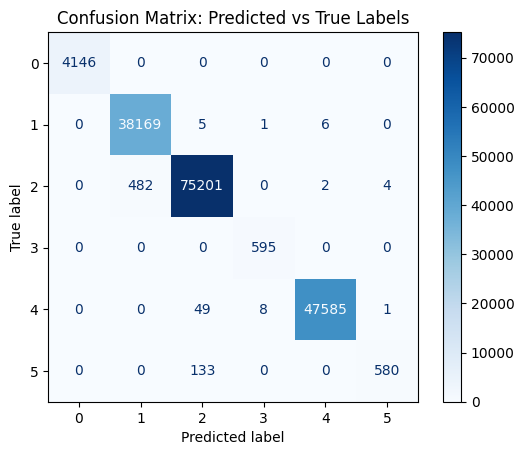

In [35]:
# Predict class probabilities
pred = model.predict(x_test)

# Choose the class with the highest probability
pred_labels = pred.argmax(axis=1)

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print(classification_report(y_test, pred_labels))

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred_labels))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: Predicted vs True Labels")
plt.show()


PermutationExplainer explainer: 201it [00:17,  5.03it/s]                         
C:\Users\luca.lucchina\AppData\Local\Temp\ipykernel_18552\1646850743.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, x_test[:200], feature_names=x_test.columns)


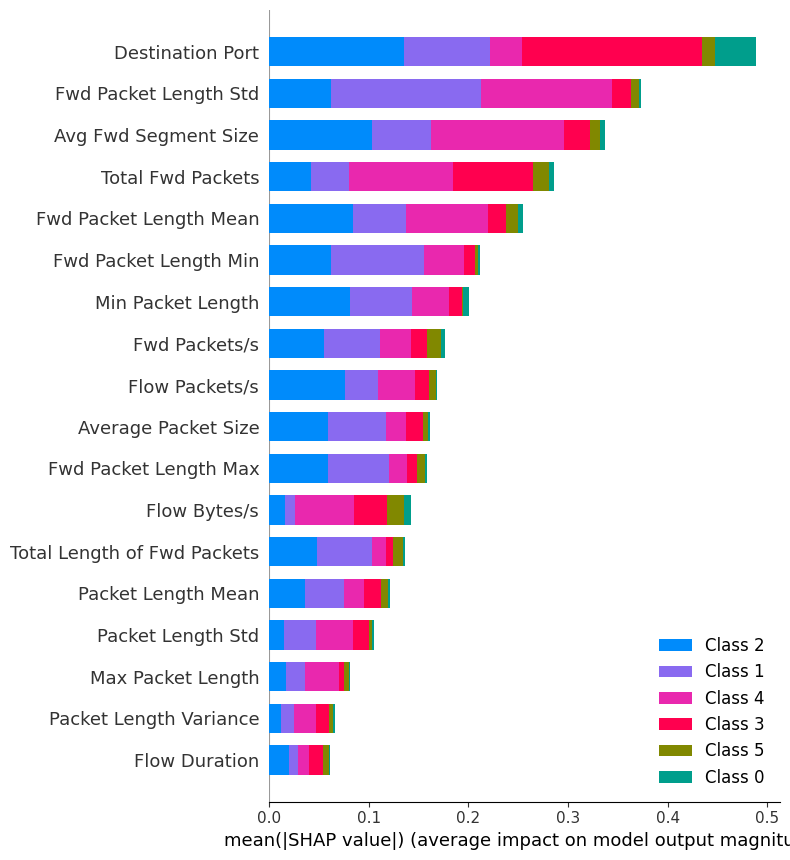

In [36]:
import shap

background = x_train.iloc[np.random.choice(x_train.shape[0], 100, replace=False)]

explainer = shap.Explainer(model, background)
shap_values = explainer(x_test[:200])

shap.summary_plot(shap_values, x_test[:200], feature_names=x_test.columns)

# neural network

In [37]:
class SelectiveConsistencyModel(tf.keras.Model):
    def __init__(self, base_model, lambda_consistency=0.3, noise_stddev=0.05):
        super().__init__()
        self.base_model = base_model
        self.lambda_consistency = lambda_consistency
        self.noise_stddev = noise_stddev
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    def call(self, inputs, training=False):
        return self.base_model(inputs, training=training)
        
    def train_step(self, data):
        (x_batch, labeled_mask), y_batch, sample_weight = data

        pseudo_mask = tf.logical_not(labeled_mask)
        noise = tf.random.normal(tf.shape(x_batch), mean=0.0, stddev=self.noise_stddev)
        x_aug = tf.where(tf.expand_dims(pseudo_mask, -1), x_batch + noise, x_batch)

        with tf.GradientTape() as tape:
            pred = self(x_batch, training=True)

            labeled_mask_float = tf.cast(labeled_mask, tf.float32)
            pseudo_mask_float = 1.0 - labeled_mask_float

            # -------- Labeled Supervised Loss --------
            labeled_indices = tf.where(labeled_mask)
            labeled_preds = tf.gather(pred, labeled_indices[:, 0])
            labeled_targets = tf.gather(y_batch, labeled_indices[:, 0])

            loss_labeled = tf.keras.losses.sparse_categorical_crossentropy(labeled_targets, labeled_preds)
            sample_weight_labeled = tf.gather(sample_weight, labeled_indices[:, 0])
            loss_labeled = tf.reduce_sum(loss_labeled * sample_weight_labeled)

            # -------- Pseudo-Labeled KL Loss (now fixed) --------
            pseudo_indices = tf.where(pseudo_mask)

            def compute_kl_loss():
                pseudo_preds = tf.gather(pred, pseudo_indices[:, 0])
                # Convert hard labels to one-hot vectors for KL divergence
                pseudo_targets = tf.one_hot(tf.gather(y_batch, pseudo_indices[:, 0]), depth=pred.shape[-1])
                kl_loss_fn = tf.keras.losses.KLDivergence(reduction=tf.keras.losses.Reduction.NONE)
                loss_kl = kl_loss_fn(pseudo_targets, pseudo_preds)
                sw = tf.gather(sample_weight, pseudo_indices[:, 0])
                return tf.reduce_sum(loss_kl * sw), tf.reduce_sum(sw)

            def zero_kl_loss():
                return tf.constant(0.0), tf.constant(0.0)

            loss_pseudo, sample_weight_pseudo = tf.cond(
                tf.shape(pseudo_indices)[0] > 0,
                true_fn=compute_kl_loss,
                false_fn=zero_kl_loss
            )

            # -------- Total Supervised Loss (normalized) --------
            total_samples = tf.reduce_sum(sample_weight_labeled) + sample_weight_pseudo + 1e-8
            loss_supervised = (loss_labeled + loss_pseudo) / total_samples

            # -------- Consistency Loss --------
            pred_aug = self(x_aug, training=True)
            consistency_mask = tf.expand_dims(pseudo_mask_float, -1)
            loss_consistency = tf.reduce_sum(tf.square(pred - pred_aug) * consistency_mask) / (
                tf.reduce_sum(pseudo_mask_float) + 1e-8
            )

            # -------- Total Loss --------
            total_loss = loss_supervised + self.lambda_consistency * loss_consistency

        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        self.loss_tracker.update_state(total_loss)
        self.compiled_metrics.update_state(y_batch, pred)

        return {
            "loss": self.loss_tracker.result(),
            **{m.name: m.result() for m in self.metrics}
        }


    def test_step(self, data):
        x, y = data
        preds = self(x, training=False)
        loss = self.compute_loss(x, y, preds)
        for metric in self.metrics:
            metric.update_state(y, preds)

        return {
            "loss": loss,
            **{m.name: m.result() for m in self.metrics}
        }

In [38]:
from tensorflow.keras import layers, models

def build_main_model(input_dim, num_classes, lambda_consistency=0.5, noise_stddev=0.02):
    inp = layers.Input(shape=(input_dim,))
    
    x = layers.Dense(256, activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    out = layers.Dense(num_classes, activation='softmax')(x)

    base = Model(inp, out)
    return SelectiveConsistencyModel(base, lambda_consistency, noise_stddev)

In [39]:
def build_parent_1(input_dim, num_classes, lambda_consistency=0.5, noise_stddev=0.02):
    inp = layers.Input(shape=(input_dim,))

    x = layers.Dense(128, activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    out = layers.Dense(num_classes, activation='softmax')(x)

    base = Model(inp, out)
    return SelectiveConsistencyModel(base, lambda_consistency, noise_stddev)

In [40]:
def residual_block(x, units, dropout=0.2):
    shortcut = x
    x = Dense(units)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(dropout)(x)
    
    x = Dense(units)(x)
    x = BatchNormalization()(x)
    
    # Match dimensions if needed
    if shortcut.shape[-1] != units:
        shortcut = Dense(units)(shortcut)

    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

def build_parent_2(input_dim, num_classes, lambda_consistency=0.5, noise_stddev=0.02):
    inp = Input(shape=(input_dim,))
    x = Dense(128)(inp)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = residual_block(x, 128)
    x = residual_block(x, 64)
    x = residual_block(x, 32)

    out = Dense(num_classes, activation="softmax")(x)
    base = Model(inp, out)
    return SelectiveConsistencyModel(base, lambda_consistency, noise_stddev)

In [41]:
def train_with_curriculum(x_labeled, y_labeled, x_unlabeled, y_unlabeled_true=None,
                          n_iters=5, threshold_start=0.995, threshold_end=0.5,
                          lambda_schedule=None, noise_schedule=None, max_samples_per_step=5000):
       
    thresholds = np.linspace(threshold_start, threshold_end, n_iters)
    x_train_curr = x_labeled.copy()
    y_train_curr = y_labeled.copy()
    x_unlabeled_pool = x_unlabeled.copy()
    y_unlabeled_true_pool = y_unlabeled_true.copy() if y_unlabeled_true is not None else None

    # variables to stop early when there is a sharp drop in the number of samples added
    last_n_selected_samples = []
    initial_sample_size = x_unlabeled_pool.shape[0]
    sharp_drop_detected = False
    sharp_drop_wait_counter = 0

    samples_added_per_iter = []
    pseudo_eval_df = pd.DataFrame(index=x_unlabeled.index)
    pseudo_eval_df['true_label'] = y_unlabeled_true
    pseudo_eval_df['predicted_label'] = np.nan
    val_acc = []

    # Store original class distribution for capping logic
    original_class_counts = dict(Counter(y_labeled))
    total_original = sum(original_class_counts.values())
    original_class_ratios = {
        cls: count / total_original for cls, count in original_class_counts.items()
    }

    # allow for different max sample selection schedule
    if isinstance(max_samples_per_step, int):
        max_samples_schedule = [max_samples_per_step] * n_iters
    else:
        max_samples_schedule = max_samples_per_step


    for step, curr_thresh in enumerate(thresholds):
        print(f"\n[Curriculum Step {step+1}] Threshold = {curr_thresh:.3f}")
        lambda_val = lambda_schedule[step] if lambda_schedule else 0.5
        noise_val = noise_schedule[step] if noise_schedule else 0.05

        print(f"→ λ = {lambda_val:.3f}, Noise STD = {noise_val:.3f}")

        class_counts = dict(Counter(y_train_curr))
        total = sum(class_counts.values())
        class_percentages = {cls: round(count / total * 100, 4) for cls, count in sorted(class_counts.items())}

        print(f"→ Class distribution in x_train_curr (%): {class_percentages}")

        if step == 0:
            tracked_classes = sorted(class_counts.keys())
            class_distribution_history = {cls: [] for cls in tracked_classes}

        for cls in tracked_classes:
            class_distribution_history[cls].append(class_percentages.get(cls, 0.0))

        if step == 0:
            # Cache labeled tensors for reuse
            x_labeled_tensor = tf.convert_to_tensor(x_labeled.values, dtype=tf.float32)
            y_labeled_tensor = tf.convert_to_tensor(y_labeled, dtype=tf.int32)
            sample_weights = compute_sample_weight('balanced', y=y_labeled)
            sample_weights_tensor = tf.convert_to_tensor(sample_weights, dtype=tf.float32)

            labeled_dataset = tf.data.Dataset.from_tensor_slices(
                ((x_labeled_tensor, tf.ones_like(y_labeled_tensor, dtype=tf.bool)),
                y_labeled_tensor, sample_weights_tensor)
            ).shuffle(10000).batch(32)

            # === Initial training of main model ===
            main_model = build_main_model(input_dim=x_labeled.shape[1],
                                        num_classes=len(np.unique(y_train_curr)),
                                        lambda_consistency=lambda_val,
                                        noise_stddev=noise_val)
            main_model.compile(optimizer='adam', metrics=['accuracy'])

            main_model.fit(labeled_dataset, epochs=15, verbose=1,
                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, min_delta=0.002)])

            # === Train parents initially ===
            parent_1 = build_parent_1(input_dim=x_train_curr.shape[1],
                                    num_classes=len(np.unique(y_train_curr)),
                                    lambda_consistency=lambda_val,
                                    noise_stddev=noise_val)
            parent_2 = build_parent_2(input_dim=x_train_curr.shape[1],
                                    num_classes=len(np.unique(y_train_curr)),
                                    lambda_consistency=lambda_val,
                                    noise_stddev=noise_val)

            for parent in [parent_1, parent_2]:
                print(f"→ Training parent model {parent.name}")
                parent.compile(optimizer='adam', metrics=['accuracy'])
                parent.fit(labeled_dataset, epochs=7, verbose=1,
                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, min_delta=0.001)])

        else:
            # === Curriculum step: pseudo-labeled data now included in x_train_curr / y_train_curr ===

            # Extract pseudo-labeled part (after original labeled data)
            x_pseudo = x_train_curr.iloc[len(x_labeled):]
            y_pseudo = y_train_curr[len(y_labeled):]

            # Merge full training data
            x_all = np.vstack([x_labeled.values, x_pseudo.values])
            y_all = np.concatenate([y_labeled, y_pseudo])

            # Labeled mask: True for original labels, False for pseudo-labeled
            labeled_mask = np.concatenate([
                np.ones(len(x_labeled), dtype=bool),
                np.zeros(len(x_pseudo), dtype=bool)
            ])

            # Weighting: Pseudo-labeled data gets lower confidence
            sample_weights = np.where(labeled_mask, 1.0, 0.4)
            balanced_weights = compute_sample_weight('balanced', y=y_all)
            sample_weights *= balanced_weights

            # Convert to tensors once
            x_tensor = tf.convert_to_tensor(x_all, dtype=tf.float32)
            y_tensor = tf.convert_to_tensor(y_all, dtype=tf.int32)
            mask_tensor = tf.convert_to_tensor(labeled_mask, dtype=tf.bool)
            sample_weights_tensor = tf.convert_to_tensor(sample_weights, dtype=tf.float32)

            # Build training dataset
            train_dataset = tf.data.Dataset.from_tensor_slices(
                ((x_tensor, mask_tensor), y_tensor, sample_weights_tensor)
            ).shuffle(10000).batch(32)

            # === Fine-tune main model ===
            main_model.fit(train_dataset, epochs=5, verbose=1,
                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, min_delta=0.002)])

            # === Retrain parents every 3 steps ===
            if step % 3 == 0:
                parent_1 = build_parent_1(input_dim=x_train_curr.shape[1],
                                        num_classes=len(np.unique(y_train_curr)),
                                        lambda_consistency=lambda_val,
                                        noise_stddev=noise_val)
                parent_2 = build_parent_2(input_dim=x_train_curr.shape[1],
                                        num_classes=len(np.unique(y_train_curr)),
                                        lambda_consistency=lambda_val,
                                        noise_stddev=noise_val)

                for parent in [parent_1, parent_2]:
                    print(f"→ Retraining parent model {parent.name}")
                    parent.compile(optimizer='adam', metrics=['accuracy'])
                    parent.fit(train_dataset, epochs=7, verbose=0,
                            callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)])

        if x_unlabeled_pool.empty:
            print("No unlabeled data left. Stopping early.")
            break

        pred_probs = main_model.predict(x_unlabeled_pool.values)
        parent_1_probs = parent_1.predict(x_unlabeled_pool.values)
        parent_2_probs = parent_2.predict(x_unlabeled_pool.values)

        pred_classes = np.argmax(pred_probs, axis=1)
        parent_1_classes = np.argmax(parent_1_probs, axis=1)
        parent_2_classes = np.argmax(parent_2_probs, axis=1)
        confidences = np.max(pred_probs, axis=1)

        # Full agreement: parents agree AND student matches them
        parent_agreement = parent_1_classes == parent_2_classes
        student_agreement = pred_classes == parent_1_classes
        agreement_mask = parent_agreement & student_agreement
        print(f"→ Full agreement (student + both parents): ({np.sum(agreement_mask)} samples)")


        sorted_preds = np.sort(pred_probs, axis=1)
        top1 = sorted_preds[:, -1]
        top2 = sorted_preds[:, -2] if pred_probs.shape[1] >= 2 else np.zeros_like(top1)
        margin = top1 - top2
        conf = (confidences >= curr_thresh)
        entropy = -np.sum(pred_probs * np.log(pred_probs + 1e-8), axis=1)
        entropy_mask = entropy < 0.3

        high_conf_mask = (
            conf &
            (margin > 0.1) &
            entropy_mask &
            agreement_mask
        )

        confident_indices_by_class = {}
        total_confident = 0

        for class_idx in range(pred_probs.shape[1]):
            class_mask = (pred_classes == class_idx) & high_conf_mask
            class_indices = np.where(class_mask)[0]
            confident_indices_by_class[class_idx] = class_indices
            total_confident += len(class_indices)

        selected_indices = []


        if total_confident == 0:
            print("→ No confident samples across all classes. Skipping this step.")
            continue

        current_class_counts = dict(Counter(y_train_curr))

        for class_idx, indices in confident_indices_by_class.items():
            print(f"→ Class {class_idx}: {len(indices)} confident samples")
            if len(indices) == 0:
                continue

            class_fraction = len(indices) / total_confident
            min_per_class = 10

            # Cap maximum samples per class: original ratio × current size × constant (1.3)
            #original_ratio = original_class_ratios.get(class_idx, 0)
            #allowed_total_for_class = int(original_ratio * (len(x_labeled) + len(x_unlabeled)) * 6)
            #already_have = current_class_counts.get(class_idx, 0)
            #max_addable = max(0, allowed_total_for_class - already_have)

            # Proportional allocation
            curr_max_samples = max_samples_schedule[step]
            n_select = max(int(class_fraction * curr_max_samples), min_per_class)
            #n_select = min(n_select, len(indices), max_addable)
            #print(class_idx, n_select)

            if n_select <= 0:
                continue

            top_indices = np.argsort(confidences[indices])[-n_select:]
            selected = indices[top_indices]
            selected_indices.extend(selected)

        selected_indices = np.array(selected_indices)

        if len(selected_indices) == 0:
            print("→ No confident samples. Skipping this step.")
            continue

        x_high_conf = x_unlabeled_pool.iloc[selected_indices]
        y_high_conf = pred_classes[selected_indices]

        pseudo_eval_df.loc[x_high_conf.index, 'predicted_label'] = y_high_conf

        if y_unlabeled_true_pool is not None:
            y_true_new = y_unlabeled_true_pool.loc[x_high_conf.index]
            acc = accuracy_score(y_true_new, y_high_conf)
            print(f"→ Pseudo-label accuracy this step: {acc:.4f}")
            val_acc.append(acc)
            y_unlabeled_true_pool = y_unlabeled_true_pool.drop(index=x_high_conf.index)

        x_unlabeled_pool = x_unlabeled_pool.drop(index=x_high_conf.index)
        x_train_curr = pd.concat([x_train_curr, x_high_conf], axis=0)
        y_train_curr = np.concatenate([y_train_curr, y_high_conf], axis=0)

        samples_added_per_iter.append(len(y_high_conf))
        print(f"→ Added {len(y_high_conf)} pseudo-labeled samples (total: {len(x_train_curr)})")
        last_n_selected_samples.append(len(y_high_conf))
        print(f"→ Recent selected counts: {last_n_selected_samples}, sum of last 2: {sum(last_n_selected_samples[-2:])}")
        
        # check if there is a sharp decrease in the number of samples added
        if len(last_n_selected_samples) >= 3:
            recent_samples = last_n_selected_samples[-3:]
            if sum(recent_samples[-2:]) < 50:
                print("🛑 No recovery after sharp drop and sufficient samples used. Stopping early.")
                break

    return thresholds[:len(samples_added_per_iter)], samples_added_per_iter, pseudo_eval_df, class_distribution_history

In [42]:
def plot_curriculum_progress(thresholds, sample_counts, val_accuracies=None):
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.set_xlabel('Confidence Threshold')
    ax1.set_ylabel('# Pseudo-Labeled Samples', color='blue')
    ax1.plot(thresholds, sample_counts, marker='o', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.invert_xaxis()

    if val_accuracies:
        ax2 = ax1.twinx()
        ax2.set_ylabel('Validation Accuracy', color='green')
        ax2.plot(thresholds, val_accuracies, marker='s', linestyle='--', color='green')
        ax2.tick_params(axis='y', labelcolor='green')

    plt.title('Curriculum Learning Progress')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_class_distribution_over_time(class_distribution_history):
    plt.figure(figsize=(10, 6))
    for cls, values in class_distribution_history.items():
        plt.plot(range(1, len(values) + 1), values, label=f"Class {cls}")

    plt.xlabel("Curriculum Step")
    plt.ylabel("Class Percentage in x_train_curr (%)")
    plt.title("Class Distribution in Training Data Over Time")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


now with a different initial sample seed

In [43]:
n_iters = 15
lambda_schedule = np.linspace(0.6, 0.15, n_iters).tolist()
noise_schedule = np.linspace(0.01, 0.01, n_iters).tolist()

max_samples_schedule = [len(x_unlabeled) // d for d in [20, 16, 12, 8]]
if len(max_samples_schedule) < n_iters:
    max_samples_schedule += [max_samples_schedule[-1]] * (n_iters - len(max_samples_schedule))

thresholds, counts, eval_df, class_distribution_history = train_with_curriculum(
    x_labeled, y_labeled, x_unlabeled,
    n_iters=n_iters,
    lambda_schedule=lambda_schedule,
    noise_schedule=noise_schedule,
    max_samples_per_step=max_samples_schedule
)


[Curriculum Step 1] Threshold = 0.995
→ λ = 0.600, Noise STD = 0.010
→ Class distribution in x_train_curr (%): {0: 2.4853, 1: 23.0031, 2: 45.2267, 3: 0.3599, 4: 28.5333, 5: 0.3917}
Epoch 1/15
17393/17393 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - accuracy: 0.9664 - loss: 0.1658
Epoch 2/15
17393/17393 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - accuracy: 0.9771 - loss: 0.1672
Epoch 3/15
17393/17393 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - accuracy: 0.9795 - loss: 0.1666
Epoch 4/15
17393/17393 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - accuracy: 0.9794 - loss: 0.1668
Epoch 5/15
17393/17393 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - accuracy: 0.9813 - loss: 0.1662
Epoch 6/15
17393/17393 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - accuracy: 0.9780 - loss: 0.1681
Epoch 7/15
17393/17393 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - accuracy: 0.9816 - loss: 0.1670
Epoch 8/15
17393/17393 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 0.9819 - loss: 0.1663
Epoch 9/15
17393/17393 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - accuracy: 0.9816 - loss: 0.1666

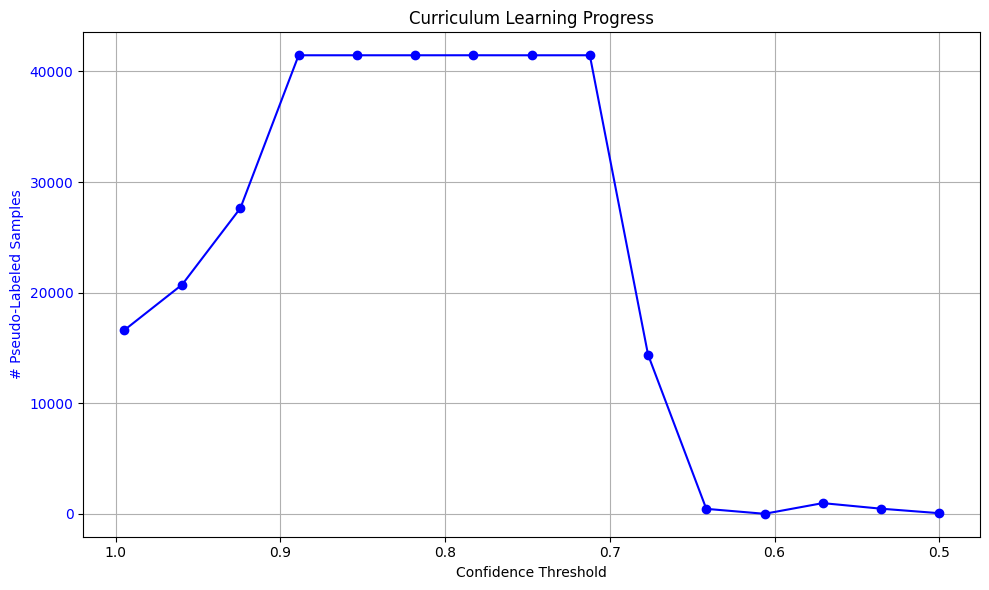

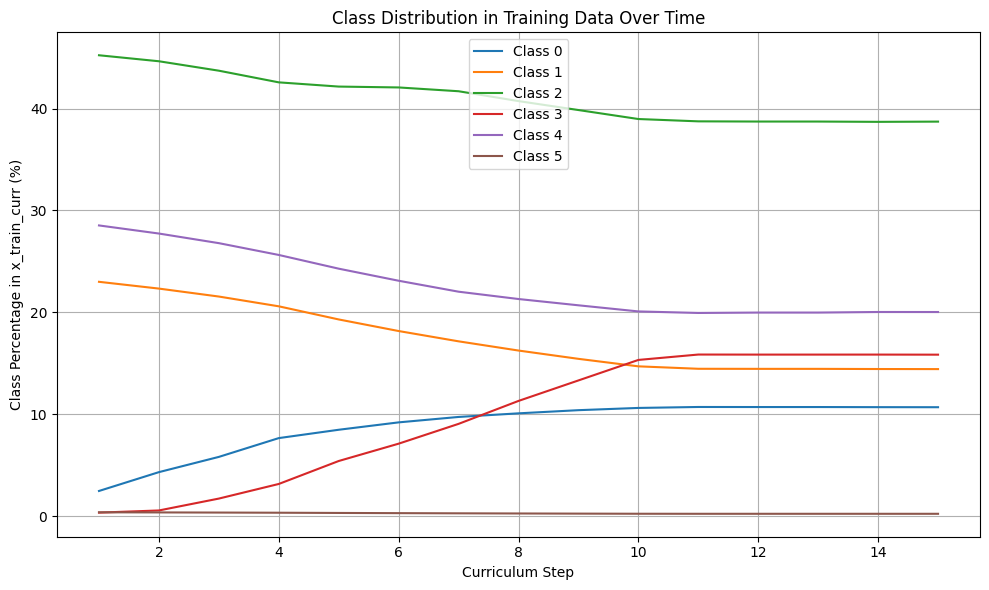

In [44]:
plot_curriculum_progress(thresholds, counts)
plot_class_distribution_over_time(class_distribution_history)

In [45]:
print(eval_df.isna().sum())

true_label         331740
predicted_label      1630
dtype: int64


In [46]:
eval_df["predicted_label"].value_counts()

predicted_label
3.0    138578
2.0     91621
0.0     81042
4.0     18869
Name: count, dtype: int64

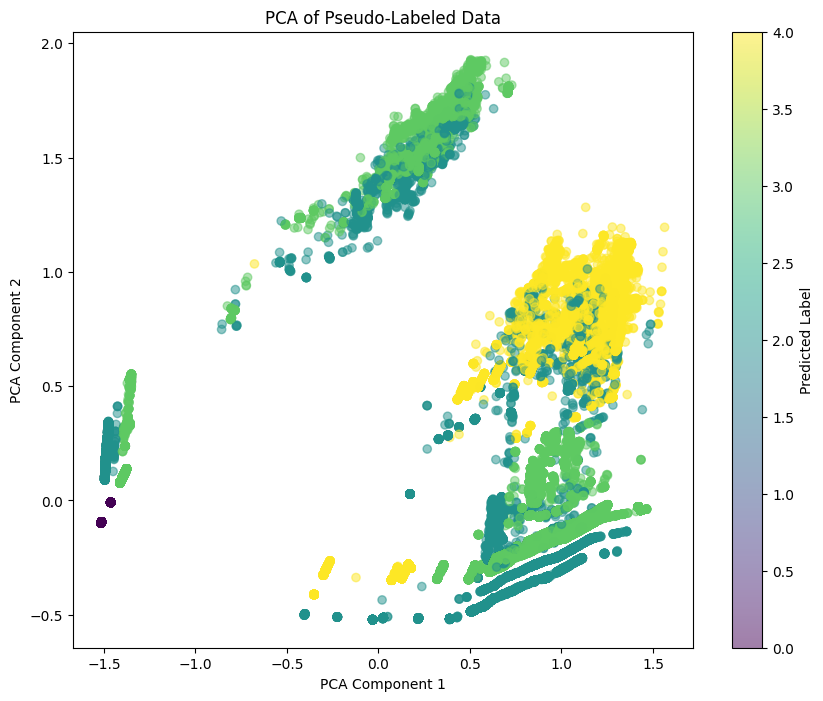

In [47]:
# pca plot of pseudo-labeled data
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(x_unlabeled)
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=eval_df['predicted_label'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Predicted Label')
plt.title('PCA of Pseudo-Labeled Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [48]:
df_labeled = x_labeled.copy()
df_labeled['label'] = y_labeled.values if isinstance(y_labeled, pd.Series) else y_labeled
df_labeled['source'] = 'Labeled'

# Step 2: Create a DataFrame from x_unlabeled with predicted labels and source info
df_unlabeled = x_unlabeled.copy()
df_unlabeled['label'] = eval_df['predicted_label'].values
df_unlabeled['source'] = 'Unlabeled'

# Step 3: Combine the two
df_combined = pd.concat([df_labeled, df_unlabeled], ignore_index=True)

# Step 4: PCA (no scaling needed)
feature_cols = df_combined.drop(columns=['label', 'source']).columns
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_combined[feature_cols])
df_combined['PCA1'] = X_pca[:, 0]
df_combined['PCA2'] = X_pca[:, 1]


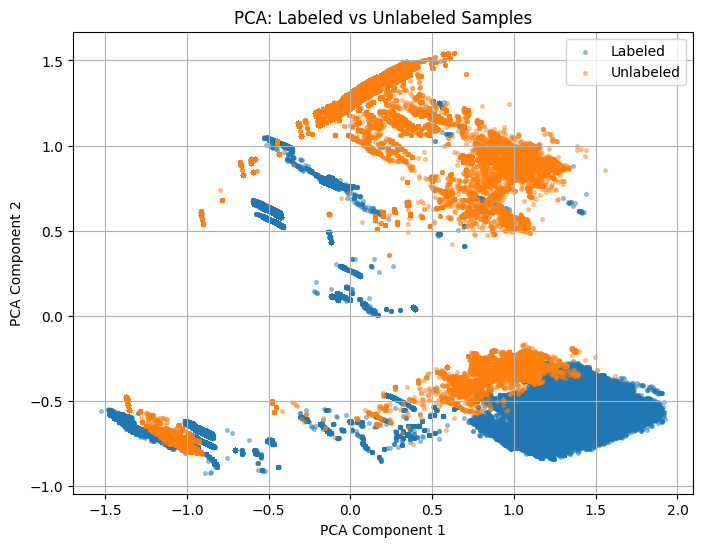

In [49]:
plt.figure(figsize=(8, 6))
for src in ['Labeled', 'Unlabeled']:
    subset = df_combined[df_combined['source'] == src]
    plt.scatter(subset['PCA1'], subset['PCA2'], label=src, alpha=0.4, s=7)
plt.legend()
plt.title("PCA: Labeled vs Unlabeled Samples")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()


C:\Users\luca.lucchina\AppData\Local\Temp\ipykernel_18552\3860532471.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(
C:\Users\luca.lucchina\AppData\Local\Temp\ipykernel_18552\3860532471.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="Source")


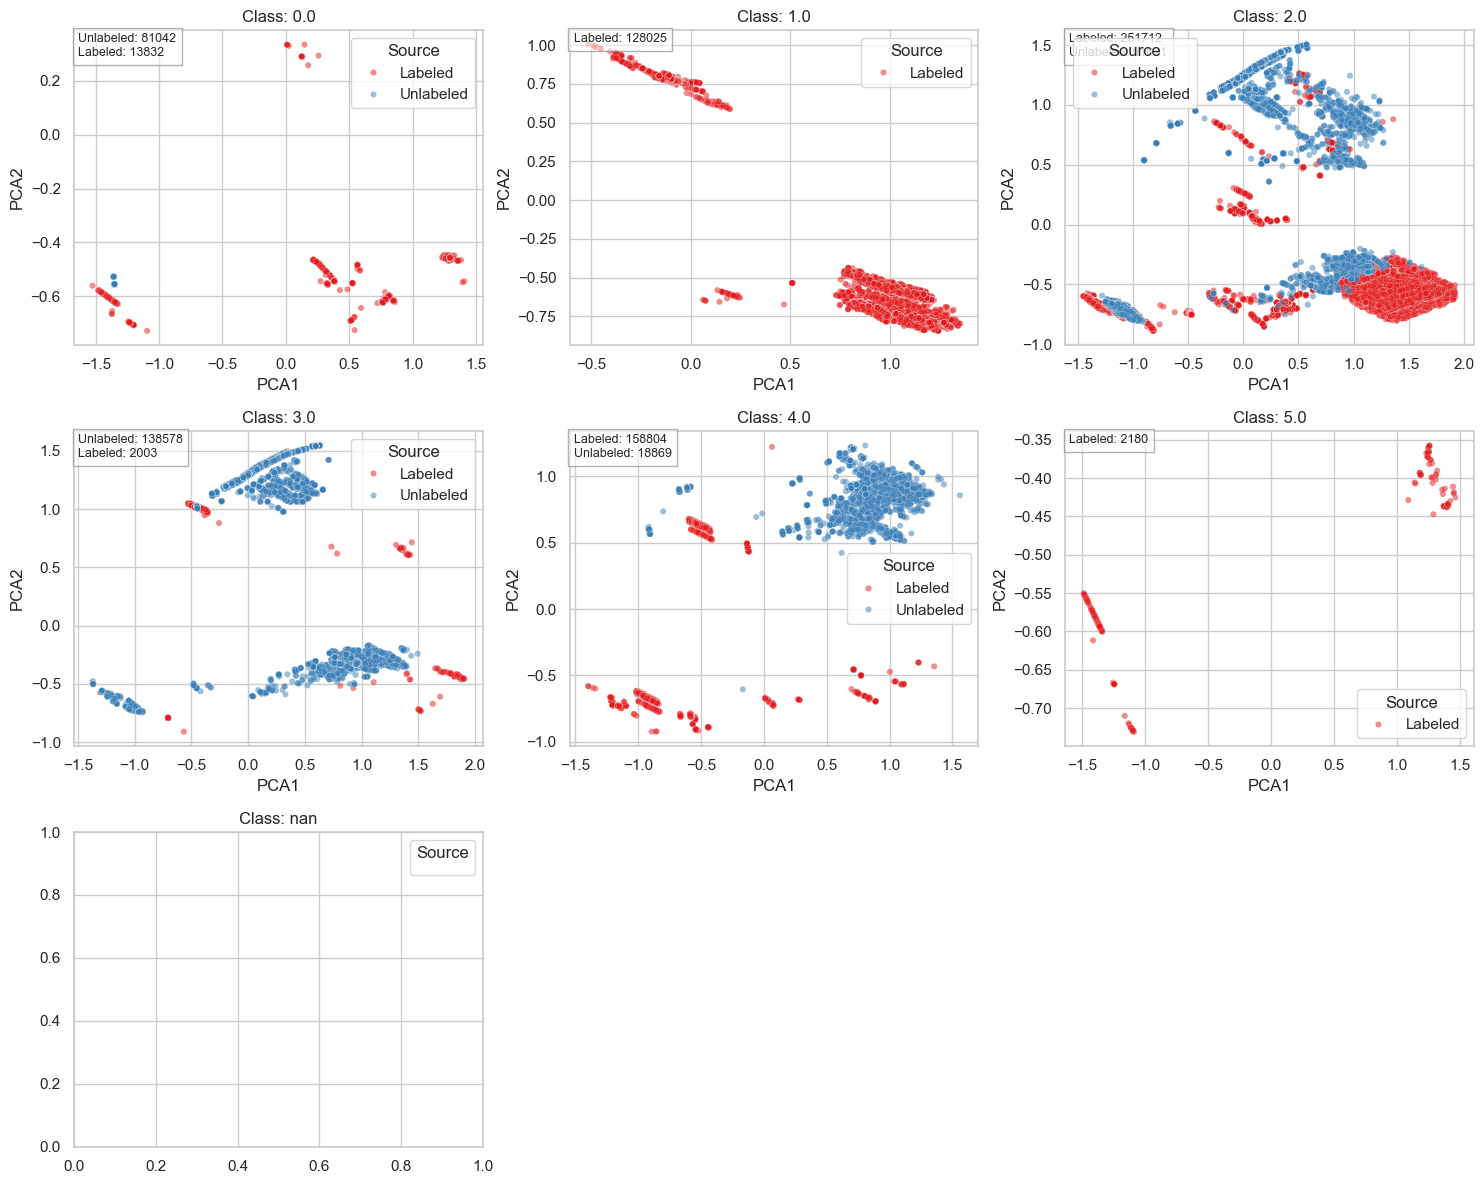

In [52]:
class_labels = df_combined["label"].unique()

# Set up subplots
n_classes = len(class_labels)
n_cols = 3
n_rows = -(-n_classes // n_cols)  # ceil division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), squeeze=False)

for idx, label in enumerate(sorted(class_labels)):
    ax = axes[idx // n_cols][idx % n_cols]
    
    df_class = df_combined[df_combined["label"] == label]
    
    sns.scatterplot(
        data=df_class,
        x="PCA1", y="PCA2",
        hue="source",  # labeled/unlabeled
        palette="Set1",
        alpha=0.5,
        s=20,
        ax=ax,
        linewidth=0.2
    )

    # Count labeled/unlabeled
    counts = df_class["source"].value_counts().to_dict()
    count_text = "\n".join([f"{src}: {count}" for src, count in counts.items()])

    # Add text in top left corner
    ax.text(
        0.01, 0.99, count_text,
        transform=ax.transAxes,
        verticalalignment='top',
        horizontalalignment='left',
        fontsize=9,
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray')
    )

    ax.set_title(f"Class: {label}")
    ax.legend(title="Source")
    ax.grid(True)

# Remove unused axes
for i in range(n_classes, n_rows * n_cols):
    fig.delaxes(axes[i // n_cols][i % n_cols])

plt.tight_layout()
plt.show()


In [57]:
import umap

umap_model = umap.UMAP()
umap_result = umap_model.fit_transform(df_combined[feature_cols])
df_combined["UMAP1"] = umap_result[:, 0]
df_combined["UMAP2"] = umap_result[:, 1]

C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding som

C:\Users\luca.lucchina\AppData\Local\Temp\ipykernel_18552\1839304934.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(
C:\Users\luca.lucchina\AppData\Local\Temp\ipykernel_18552\1839304934.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="Source")


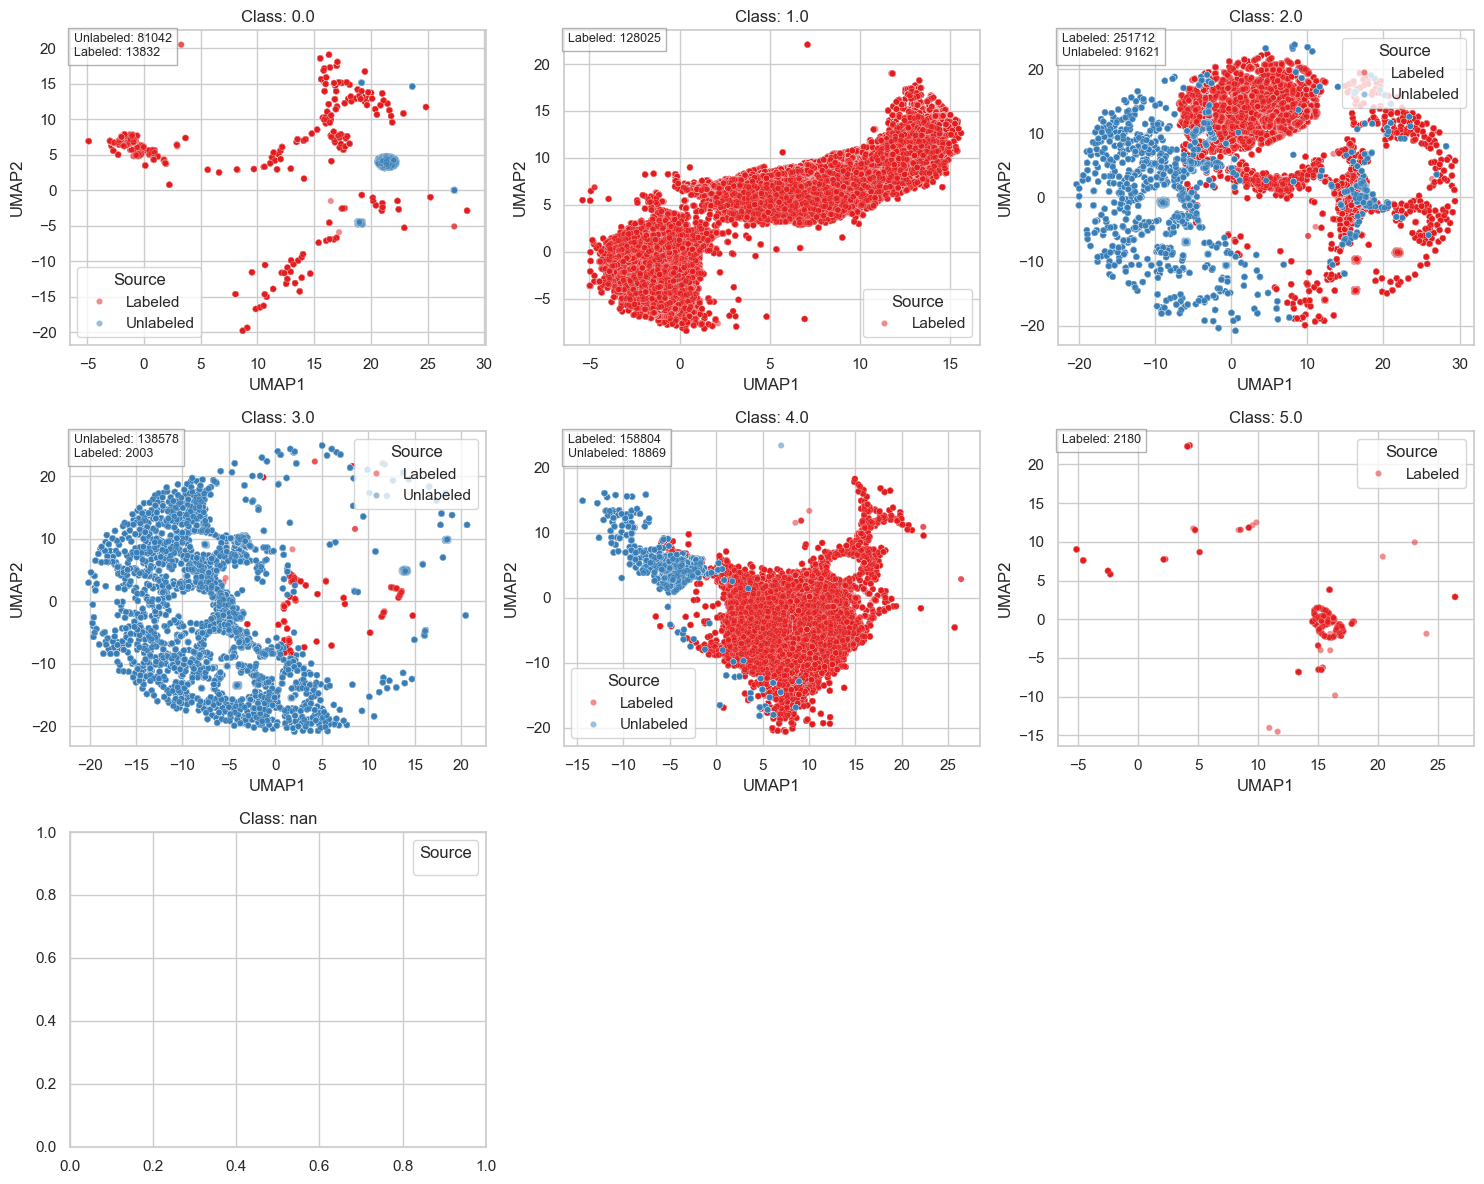

In [58]:
class_labels = df_combined["label"].unique()
n_classes = len(class_labels)
n_cols = 3
n_rows = -(-n_classes // n_cols)  # ceil division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), squeeze=False)

for idx, label in enumerate(sorted(class_labels)):
    ax = axes[idx // n_cols][idx % n_cols]
    
    df_class = df_combined[df_combined["label"] == label]
    
    sns.scatterplot(
        data=df_class,
        x="UMAP1", y="UMAP2",
        hue="source",  # e.g., labeled / unlabeled
        palette="Set1",
        alpha=0.5,
        s=20,
        ax=ax,
        linewidth=0.2
    )
    
    # Count labeled/unlabeled
    counts = df_class["source"].value_counts().to_dict()
    count_text = "\n".join([f"{src}: {count}" for src, count in counts.items()])
    
    ax.text(
        0.01, 0.99, count_text,
        transform=ax.transAxes,
        verticalalignment='top',
        horizontalalignment='left',
        fontsize=9,
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray')
    )

    ax.set_title(f"Class: {label}")
    ax.legend(title="Source")
    ax.grid(True)

# Remove unused subplots
for i in range(n_classes, n_rows * n_cols):
    fig.delaxes(axes[i // n_cols][i % n_cols])

plt.tight_layout()
plt.show()


feed forward 3 layers 256-64, 0.6-0.25 lambda 0.01 noise 15 steps, 3 class proportianality, cnofidence threshold 0.995 to 0.85, scheduling max sample per step -->

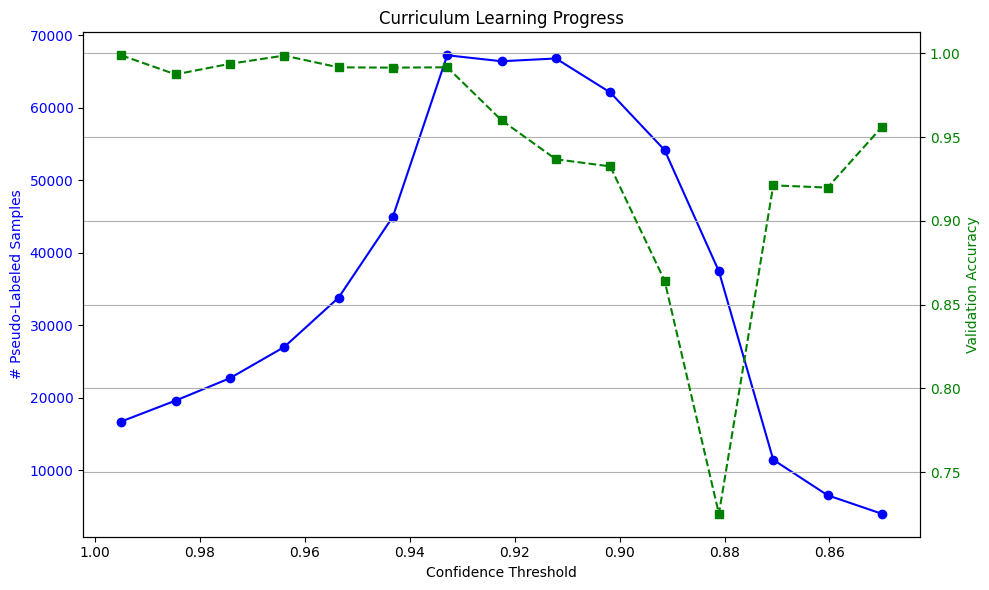

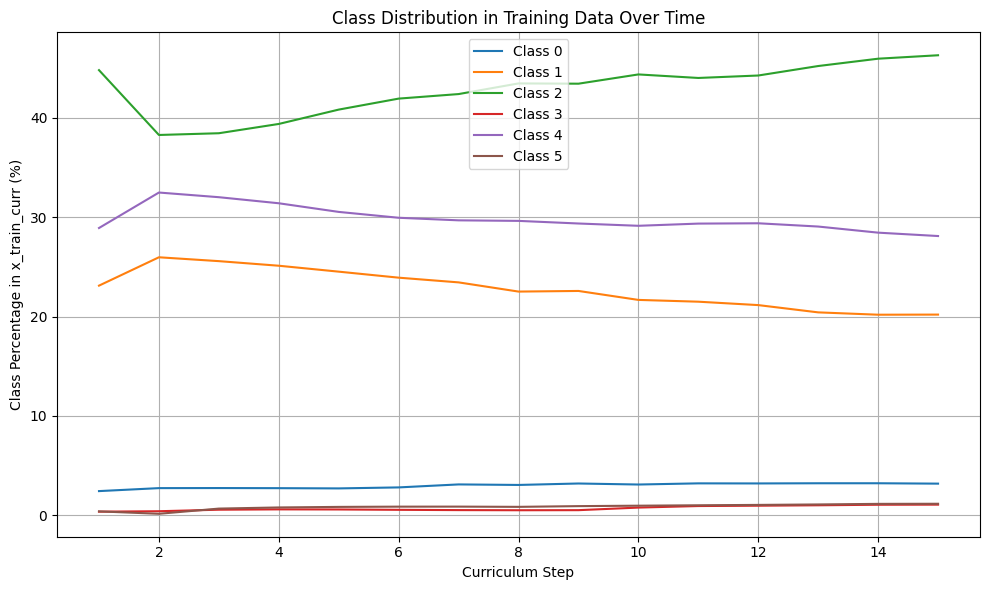

In [ ]:
plot_curriculum_progress(thresholds, counts, accs)
plot_class_distribution_over_time(class_distribution_history, thresholds)

In [ ]:
print(eval_df.isna().sum())
eval_df.dropna(subset=['predicted_label'], inplace=True)
y_true_final = eval_df['true_label'].astype(int)
y_pred_final = eval_df['predicted_label'].astype(int)

true_label            0
predicted_label    5944
dtype: int64


              precision    recall  f1-score   support

           0       0.76      0.95      0.84     13589
           1       0.99      0.85      0.92    125682
           2       0.93      0.97      0.95    241334
           3       0.33      0.99      0.50      1967
           4       1.00      0.97      0.98    155909
           5       0.28      0.84      0.42      2131

    accuracy                           0.94    540612
   macro avg       0.71      0.93      0.77    540612
weighted avg       0.95      0.94      0.94    540612



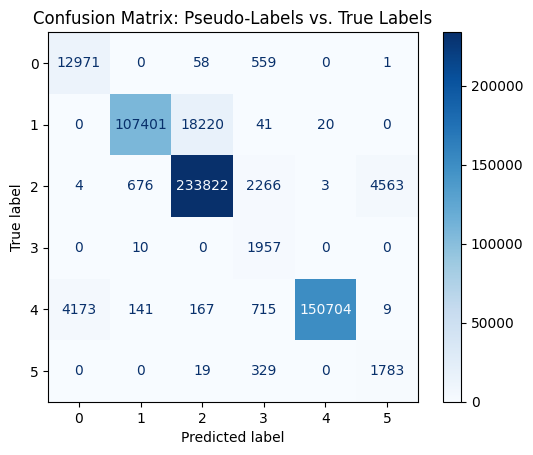

In [ ]:
print(classification_report(y_true_final, y_pred_final))

cm = confusion_matrix(y_true_final, y_pred_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: Pseudo-Labels vs. True Labels")
plt.show()
